In [1]:
import sys
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import utils
from sklearn import linear_model, decomposition, datasets, cross_validation
from sklearn import ensemble, cross_validation
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [7]:
reload(utils)
drivers = ["1", "2", "3",]  # "10", "11", "12", "13", "14", "15"]
folders = os.listdir("drivers/")
drivers = filter(lambda idd: idd[0] != "." and 0<int(idd)<130, folders)
sc = np.zeros(len(drivers))
stds = np.zeros(len(drivers))
#params = {'n_estimators': 600, 'max_depth': 5, 'min_samples_split': 2,
#              'learning_rate': 0.1}

params = {
    'n_estimators': 400, 
    'max_depth': 3,
    'learning_rate': 0.5
}

clf = ensemble.GradientBoostingClassifier(**params)
#clf = linear_model.LogisticRegression(C=1.0, penalty='l1')

_samples = 400
_n_clean = 200

Xf, yf = utils.load_outliers_pca("1", _samples-200)

tot_X = np.zeros((len(drivers) * (_samples), utils._COMP_PCA))
tot_y = np.zeros((len(drivers) * (_samples)))
real_X = np.zeros((len(drivers) * 200, utils._COMP_PCA))

folds = []

for i, d in enumerate(drivers):
    Xt, yt = utils.load_driver_pca(d)
    yt[:] = 1
    yt[_n_clean:] = 0
    real_X[i*200:(i+1)*200, :] = Xt
    X = np.vstack((Xt, Xf))
    y = np.hstack((yt, yf))
    k_fold = cross_validation.KFold(len(X), n_folds=5)
    X, y = shuffle(X, y, random_state=13)
    folds.append(k_fold)
    tot_X[i*_samples:(i+1)*_samples, :] = X
    tot_y[i*_samples:(i+1)*_samples] = y
    score = cross_validation.cross_val_score(clf, X, y, cv=k_fold, n_jobs=-1)
    print d, score.mean(), score.std()
    sc[i] = score.mean()
    stds[i] = score.std()
print sc.mean(), stds.mean()

1 0.735 0.0266926956301
10 0.74 0.0572276157113
100 0.725 0.032596012026
101 0.7625 0.0586301969978
102 0.84 0.031024184115
103 0.845 0.0497493718553
104 0.84 0.0398434436263
105 0.71 0.0463680924775
106 0.86 0.031024184115
107 0.8075 0.0451386752132
108 0.7675 0.0539675828623
109 0.8125 0.0541987084717
11 0.75 0.04472135955
110 0.79 0.028939592257
111 0.8 0.0395284707521
112 0.835 0.0242383992871
113 0.805 0.035881750236
114 0.8425 0.0478278161743
115 0.8425 0.0437321392113
116 0.775 0.0410791918129
117 0.7775 0.03
118 0.8525 0.02
119 0.8 0.0395284707521
12 0.66 0.0598957427536
120 0.85 0.0273861278753
121 0.67 0.062549980016
122 0.72 0.0375832409459
123 0.765 0.0390512483795
125 0.6925 0.0522015325446
126 0.675 0.022360679775
127 0.7275 0.0365718470958
128 0.8175 0.0257390753525
129 0.7525 0.0145773797371
13 0.825 0.0344601218802
14 0.8075 0.0527967802049
15 0.765 0.0489897948557
16 0.7275 0.0566789202438
17 0.7775 0.0365718470958
18 0.83 0.0471699056603
19 0.795 0.0527967802049
2 0.

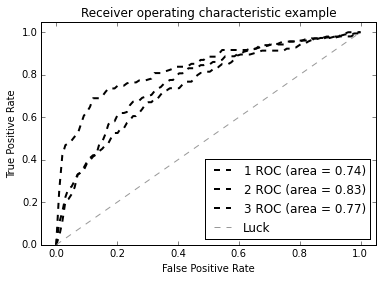

In [7]:
from scipy import interp

for j, d in enumerate(drivers):
    X = tot_X[j*_samples:(j+1)*_samples, :]
    y = tot_y[j*_samples:(j+1)*_samples]
    k_fold = folds[j]
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    d_p = np.zeros((200))
    for i, (train, test) in enumerate(k_fold):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        my_p = clf.predict_proba(real_X[j*200:(j+1)*200, :])[:, 1]
        d_p += my_p
        #print p[:10]
        #print np.histogram(p, bins=np.linspace( 0, 1 , 5))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    d_p /= float(len(k_fold))
    # qui salva d_p su il file
    # print np.histogram(d_p, bins=np.linspace( 0, 0.005625 , 5))
    mean_tpr /= len(k_fold)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='%s ROC (area = %0.2f)' % (d, mean_auc), lw=2)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [18]:
clf2 = ensemble.GradientBoostingClassifier(max_depth=4)
n_est = np.linspace(200, 600, 8).astype(int)
lr = np.linspace(0.01, 0.08, 8)
best_i = 0
best_scores = np.zeros((len(drivers)))
vals = np.zeros((len(drivers), 2))

for j, d in enumerate(drivers):
    X = tot_X[j*_samples:(j+1)*_samples, :]
    y = tot_y[j*_samples:(j+1)*_samples]
    X, y = shuffle(X, y, random_state=13)
    clf = GridSearchCV(estimator=clf2, param_grid=dict(n_estimators=n_est, learning_rate=lr),n_jobs=-1)
    clf.fit(X, y)
    best_scores[j] = clf.best_score_
    vals[j, :] = np.array([clf.best_estimator_.learning_rate, clf.best_estimator_.n_estimators])
    print (j+1)/float(len(drivers)) * 100, clf.best_score_, vals[j, :]
print vals


2.94117647059 0.7025 [  8.00000000e-02   2.00000000e+02]
5.88235294118 0.7675 [  4.00000000e-02   2.57000000e+02]
8.82352941176 0.74 [  8.00000000e-02   4.85000000e+02]
11.7647058824 0.8 [  6.00000000e-02   2.57000000e+02]
14.7058823529 0.8125 [  8.00000000e-02   2.57000000e+02]
17.6470588235 0.69 [  2.00000000e-02   2.00000000e+02]
20.5882352941 0.83 [  2.00000000e-02   3.14000000e+02]
23.5294117647 0.75 [  8.00000000e-02   6.00000000e+02]
26.4705882353 0.785 [  5.00000000e-02   4.28000000e+02]
29.4117647059 0.67 [  1.00000000e-02   3.14000000e+02]
32.3529411765 0.77 [  7.00000000e-02   2.00000000e+02]


KeyboardInterrupt: 